In [1]:
import torch
import torch.nn as nn

import math
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import uniform_filter1d
import sys
import time
import cv2

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# generate random gridMaps

def getRndRoadgrid(gridSize, maxVRT=3, maxHOR=3):

    VRT = - 10 * np.ones(maxVRT)
    HOR = - 10 * np.ones(maxHOR)

    nVRT = np.random.randint(1, maxVRT+1)
    nHOR = np.random.randint(1, maxHOR+1)

    for i in range(nVRT):
        vrt = np.random.randint(0, gridSize) / gridSize
        while (np.abs(vrt - VRT) < 3/gridSize).any():
            vrt = np.random.randint(0, gridSize) / gridSize

        VRT[i:] = vrt

    for i in range(nHOR):
        hor = np.random.randint(0, gridSize) / gridSize

        while (np.abs(1 - hor - HOR) < 3/gridSize).any():
            hor = np.random.randint(0, gridSize) / gridSize

        HOR[i:] = 1 - hor

    VRT.sort(), HOR.sort()

    return VRT, HOR

In [3]:
# function to calculate centepoints of each road intersection crossed by the planner

def getIntermediateStartGoal(VRT, HOR, ssol, gridSize):
    crossings = -1 * np.ones(shape=(1,2))
    for i in range(ssol.shape[0]):

        dCrossVRT = np.abs(ssol[i,0] - VRT)
        dCrossHOR = np.abs(ssol[i,1] - HOR)

        if (dCrossVRT < 0.12).any() and (dCrossHOR < 0.12).any():
            crossVRT = VRT[np.argmin(dCrossVRT)]
            crossHOR = HOR[np.argmin(dCrossHOR)]

            cross = np.clip(np.array([crossVRT - .5/gridSize, crossHOR + .5/gridSize]), .5 / gridSize, (gridSize - .5) / gridSize)

            if not (crossings[-1] == cross).all():
                crossings = np.vstack((crossings, cross))

    crossings = crossings[1:]

    diffCrossings = np.diff(np.concatenate((start[:2].reshape(1,2), crossings, goal[:2].reshape(1,2))), axis=0)
    interStarts = np.copy(crossings)
    interGoals = np.copy(crossings)

    startAxis = np.argmax(np.abs(diffCrossings[:-1]), axis=1)
    startSign = np.sign(diffCrossings[np.arange(diffCrossings.shape[0] - 1), startAxis])
    interStarts[np.arange(interStarts.shape[0]), startAxis] -= 1.5/gridSize * startSign

    goalAxis = np.argmax(np.abs(diffCrossings[1:]), axis=1)
    goalSign = np.sign(diffCrossings[np.arange(1, diffCrossings.shape[0]), goalAxis])
    interGoals[np.arange(interGoals.shape[0]), goalAxis] += 1.5/gridSize * goalSign

    interStartYaw =-np.pi * (startAxis == 0).astype(int) * (startSign == -1).astype(int) + (startAxis == 1).astype(int) * (np.pi/2 - np.pi * (startSign == -1).astype(int))
    interGoalYaw = -np.pi * (goalAxis == 0).astype(int) * (goalSign == -1).astype(int) + (goalAxis == 1).astype(int) * (np.pi/2 - np.pi * (goalSign == -1).astype(int))

    return np.hstack((interStarts, interStartYaw.reshape(interStarts.shape[0], 1))), np.hstack((interGoals, interGoalYaw.reshape(interGoals.shape[0], 1)))

In [4]:
def propagateState(traj_x, traj_y, truckState, trailerState, statelist):
    controller = PurePursuitController()

    controller.traj_x = traj_x
    controller.traj_y = traj_y

    delta = controller.compute_control(truckState)

    ctrliter = 0
    while not controller.is_finished and ctrliter < maxCtrlIter:
        
        delta = (delta + controller.compute_control(truckState)) / 2 # helps smoothen steering input
        beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

        trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - 0.8 * b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - 0.8 * b2 * np.sin(trailerState.yaw)
        trailerState.yaw += (v * np.sin(truckState.yaw - trailerState.yaw) / (b2 + a21) - v * (b1 - a12) * np.cos(truckState.yaw - trailerState.yaw) * np.sin(beta) / (a12 * (b2 + a21))) * dt

        truckState.x += v * np.cos(truckState.yaw + beta) * dt
        truckState.y += v * np.sin(truckState.yaw + beta) * dt
        truckState.yaw += v * np.sin(beta) / a12 * dt

        statelist.append([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, delta, trailerState.x, trailerState.y]) 

        ctrliter += 1

    if not controller.is_finished:
        raise UserWarning('Exceeded max ctrl iter')

    return statelist

In [9]:
# define planning problem
class MyGoal(ob.Goal):
    def __init__(self, si, goal):
        super(MyGoal, self).__init__(si)
        self.goal = goal

    def isSatisfied(self, state):
        return np.linalg.norm(self.goal - np.array([state[0], state[1], (state[2] + np.pi) % (2 * np.pi) - np.pi])) < 0.04


def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isRV2StateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    u = int(np.floor(state[0] * gridSize)) # right pointing image axis
    v = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    if spaceInformation.satisfiesBounds(state):
        return occGrid[v,u] > 0


def isRV4Valid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    uTruck = int(np.floor(state[0] * gridSize)) # right pointing image axis
    vTruck = int(np.floor(gridSize * (1 - state[1]))) # down pointing image axis

    xTrailer = state[0] - b1 * np.cos(state[2]) - np.linspace(0, b2, 6) * np.cos(state[3])
    yTrailer = state[1] - b1 * np.sin(state[2]) - np.linspace(0, b2, 6) * np.sin(state[3])
    uTrailer = np.clip(np.floor(xTrailer * gridSize), 0, gridSize - 1).astype(int)
    vTrailer = np.clip(np.floor(gridSize * (1 - yTrailer)), 0, gridSize - 1).astype(int)

    #return True
    if spaceInformation.satisfiesBounds(state):
        return occGrid[vTruck,uTruck] > 0 and (occGrid[vTrailer,uTrailer] > 0).all() 


def propagate(start, control, duration, state):
    # global exploredStates
    # exploredStates = np.vstack((exploredStates, np.array([[state.getX(), state.getY(), state.getYaw()]])))

    beta = np.arctan(np.tan(control[0]) * a12 / (a11 + a12))

    state[0] = start[0] + v * np.cos(start[2] + beta) * duration
    state[1] = start[1] + v * np.sin(start[2] + beta) * duration
    state[2] = start[2] + v * np.sin(beta) / a12 * duration
    state[3] = start[3] + (v * np.sin(start[2] - start[3]) / (b2 + a21) - v * (b1 - a12) * np.cos(start[2] - start[3]) * np.sin(beta) / (a12 * (b2 + a21))) * duration


def problemDef(sampleCtrl=False):

    if sampleCtrl:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(4)

        # # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(4)
        bounds.setLow(0, 0.001)
        bounds.setLow(1, 0.001)
        bounds.setLow(2, -2 * np.pi)
        bounds.setLow(3, -2 * np.pi)
        bounds.setHigh(0, 0.999)
        bounds.setHigh(1, 0.999)
        bounds.setHigh(2, 2 * np.pi)
        bounds.setHigh(3, 2 * np.pi)
        space.setBounds(bounds)

        # create a control space
        cspace = oc.RealVectorControlSpace(space, 1)

        # set the bounds for the control space
        cbounds = ob.RealVectorBounds(1)
        cbounds.setLow(-0.8)
        cbounds.setHigh(0.8)
        cspace.setBounds(cbounds)

        ss = oc.SimpleSetup(cspace)
        ss.setStatePropagator(oc.StatePropagatorFn(propagate))
        si = ss.getSpaceInformation()

        si.setPropagationStepSize(.07)
        si.setMinMaxControlDuration(1, 1)
        planner = oc.RRT(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV4Valid, ss.getSpaceInformation())))

    else:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(2)

        # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(2)
        bounds.setLow(0.001)
        bounds.setHigh(0.999)
        space.setBounds(bounds)

        # define a simple setup class
        ss = og.SimpleSetup(space)
        si = ss.getSpaceInformation()
        planner = og.RRTstar(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV2StateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState, simplify=False):

    if simplify:    
        space = ob.RealVectorStateSpace(2)

        start = ob.State(space)
        start[0] = initState[0]
        start[1] = initState[1]

        goal = ob.State(space)
        goal[0] = goalState[0]
        goal[1] = goalState[1]

        planObj.setStartAndGoalStates(start, goal, 0.02)

        timeTerminationCondition = ob.timedPlannerTerminationCondition(2.)
    else:
        space = ob.RealVectorStateSpace(4)

        start = ob.State(space)
        start[0] = initState[0] # truck x
        start[1] = initState[1] # truck y
        start[2] = initState[2] # truck yaw
        start[3] = initState[3] # trailer yaw

        si = planObj.getSpaceInformation()
        planObj.setStartState(start)
        planObj.setGoal(MyGoal(si, goalState))

        timeTerminationCondition = ob.timedPlannerTerminationCondition(1.4)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=4, epsilon=1.0)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if simplify and solved:
        planObj.simplifySolution()

In [7]:
class PurePursuitController():

    k = 0.06  # look forward gain
    Lfc = 0.06  # look-ahead distance
    K_p = 1.2  #TODO speed control propotional gain
    K_i = 5.0  #TODO speed control integral gain
    K_d = 0.008  # speed control derivitive gain
    L = 0.0724  # [m] wheel base of vehicle

    def __init__(self):
        self.traj_x = []
        self.traj_y = []
        self.target = None
        self.max_vel = 0.7
        # initialize with 0 velocity
        self.target_velocity = 0.0
        self.last_index = 0
        self.last_d = 100
        self.dt = 0.01
        self.vel_error_int_sum = 0
        self.vel_error = np.array([0])  
        self.vel_error_int = np.array([0]) 
        self.vel_error_der = np.array([0]) 
        self.is_finished = False

    def compute_control(self, state, target=None):
        steering = self.compute_steering(state, target)
        velocity = self.compute_velocity(state)
        return steering

    def compute_steering(self, state, target=None):
        if target is None:
            self.find_target(state)
        else:
            # allow manual setting of target
            self.target = target

        tx, ty = self.target
        alpha = np.arctan2(ty - state.y, tx - state.x) - state.yaw
        if state.v < 0:  # back
            alpha = np.pi - alpha
        Lf = self.k * state.v + self.Lfc
        delta = np.arctan2(2.0 * self.L * 0.5 * np.sin(alpha) / Lf, 1.0)
        return delta
                                   
    def compute_velocity(self, state):
        if self.is_finished:
            # stop moving if trajectory done
            return 0.0
        else:
            # speed control
            # Append the errors to the lists2
            self.vel_error     = np.append(self.vel_error      , self.target_velocity - state.v)
            self.vel_error_int = np.append(self.vel_error_int  , self.vel_error_int[-1] + self.vel_error[-1] * self.dt)
            self.vel_error_der = np.append(self.vel_error_der  , (self.vel_error[-1] - self.vel_error[-2]) / self.dt)

            P = self.vel_error[-1] * self.K_p
            I = self.vel_error_int[-1] * self.K_i
            D = self.vel_error_der[-1] * self.K_d

            correction = P + I + D

            # Saturating the velocity at a max velocity
            return self.target_velocity + min(correction, 0)

    def find_target(self, state):
        ind = self._calc_target_index(state)
        self.last_index = ind
        tx = self.traj_x[ind]
        ty = self.traj_y[ind]
        self.target = (tx, ty)

    def _calc_target_index(self, state):
        # search nearest point index
        dx = [state.x - icx for icx in self.traj_x]
        dy = [state.y - icy for icy in self.traj_y]
        d = [abs(np.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
        ind = d.index(min(d))
        dist = 0.0
        Lf = self.k * state.v + self.Lfc

        # search look ahead target point index
        while Lf > dist and (ind + 1) < len(self.traj_x):
            dx = self.traj_x[ind + 1] - self.traj_x[ind]
            dy = self.traj_y[ind + 1] - self.traj_y[ind]
            dist += np.sqrt(dx ** 2 + dy ** 2)
            ind += 1

        # terminating condition
        if ind >= len(self.traj_x) - 1 and d[-1] < 0.08:
            self.is_finished = True

        return ind


class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

In [10]:
# generate planning scenario, plan, and perform path following

nData = 1
minDistThreshold = 0.8 # minimum distance threshold betwen start/goal
pdef = problemDef(sampleCtrl=False)
pdef_ctrl = problemDef(sampleCtrl=True)
maxCtrlIter = 60
maxInitIter = 1000
gridSize = 11

dt = 0.2 # controller time step
v =  0.1 # vehicle speed
L   = 0.05 # vehicle length constant
Lt  = 0.18 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2

trajSamples = np.zeros(shape=(1, 7)) # truckX, truckY, truckYaw, trailerX, trailerY trailerYaw, steer
initData = np.zeros(shape=(1, 3)) # x, y, yaw
goalData = np.zeros(shape=(1, 3))
obstacleData = np.zeros(shape=(1, 6))
data = np.zeros(shape=(1, trajSamples.shape[1] + initData.shape[1] + goalData.shape[1] + obstacleData.shape[1]))

# exploredStates = np.zeros(shape=(1, 3))

plotPaths = True

nPlans = 0
while nPlans < nData:

    occGrid = np.zeros(shape=(gridSize, gridSize))
    intersectGrid = np.copy(occGrid) + 1
    VRT, HOR = getRndRoadgrid(gridSize, maxVRT=3, maxHOR=3)
    VRTv, HORv = np.meshgrid((VRT * (gridSize - 1)).astype(int), ((1 - HOR) * (gridSize - 1)).astype(int), indexing='ij')

    occGrid[:, (VRT * (gridSize - 1)).astype(int)] = 1
    occGrid[((1 - HOR) * (gridSize - 1)).astype(int), :] = 1
    intersectGrid[HORv.reshape(-1), VRTv.reshape(-1)] = 0
    intersectGrid = np.floor(cv2.blur(intersectGrid, ksize=(3,3)))

    # generate starting point and goal using simple planner
    while True:
        initIter = 0
        while True and initIter < maxInitIter: # randomize starting coordinates
            initIter += 1

            start = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            goal  = np.array([np.random.uniform(low=0.001, high=0.999), np.random.uniform(low=0.001, high=0.999), 0])
            
            uStart = int(np.floor(start[0] * gridSize)) # right pointing image axis
            vStart = int(np.floor(gridSize * (1 - start[1]))) # down pointing image axis
            uGoal = int(np.floor(goal[0] * gridSize)) # right pointing image axis
            vGoal = int(np.floor(gridSize * (1 - goal[1]))) # down pointing image axis
            if np.abs(start[:2] - goal[:2]).sum() > minDistThreshold and occGrid[vStart,uStart] > 0 and occGrid[vGoal,uGoal] > 0 and intersectGrid[vStart,uStart] > 0 and intersectGrid[vGoal,uGoal]:
                break

        pdef.clear()
        plan(pdef, initState=start, goalState=goal, simplify=True)
        if pdef.getProblemDefinition().hasExactSolution() and not np.any(goalData[-1,:2] == goal[:2]): # ignore paths that consequtively start in the same pose
            break

    ssol = np.loadtxt(StringIO(pdef.getProblemDefinition().getSolutionPath().printAsMatrix()))
    
    # remove points unneccesarily close to start/goal
    ssol = ssol[1:] if np.linalg.norm(ssol[0, :2] - start[:2]) < 0.02 else ssol
    ssol = ssol[:-1] if np.linalg.norm(ssol[-1, :2] - goal[:2]) < 0.02 else ssol

    if ssol.shape[0] > 0:

        # find suitable starting/goal yaw to be used by control planner
        start_dxdy = ssol[0, :2] - start[:2]; goal_dxdy = goal[:2] - ssol[-1, :2]
        start_xydot = start_dxdy / np.linalg.norm(start_dxdy); goal_xydot = goal_dxdy / np.linalg.norm(goal_dxdy)
        start[-1] = np.sign(int(start_xydot[-1] > 0) - 0.5) * np.arccos(np.dot(start_xydot / np.linalg.norm(start_xydot), [1, 0])) # get yaw from xdot, ydot
        goal[-1] = np.sign(int(goal_xydot[-1] > 0)- 0.5) * np.arccos(np.dot(goal_xydot / np.linalg.norm(goal_xydot), [1, 0]))

        truckState = VehicleState()
        truckState.x = start[0]; truckState.y = start[1]; truckState.yaw = start[2]; truckState.v = v

        trailerState = VehicleState()
        trailerState.yaw = truckState.yaw
        trailerState.x = truckState.x - b1 * np.cos(trailerState.yaw) - b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(trailerState.yaw) - b2 * np.sin(trailerState.yaw)

        # perform control planning near each 90 degree turn
        interStarts, interGoals = getIntermediateStartGoal(VRT, HOR, ssol, gridSize)

        statelist = [[truckState.x, truckState.y, truckState.yaw, trailerState.yaw, 0, trailerState.x, trailerState.y]]

        replan = False
        for startI, goalI in zip(interStarts, interGoals):

            try:    
                statelist = propagateState(traj_x=[startI[0]], traj_y=[startI[1]], truckState=truckState, trailerState=trailerState, statelist=statelist)
            except: 
                replan = True
                break

            pdef_ctrl.clear()
            plan(pdef_ctrl, initState=[truckState.x, truckState.y, truckState.yaw, trailerState.yaw], goalState=goalI)
            if not pdef_ctrl.getProblemDefinition().hasExactSolution():
                replan = True
                break

            csol = np.loadtxt(StringIO(pdef_ctrl.getProblemDefinition().getSolutionPath().printAsMatrix()))

            try:    
                statelist = propagateState(traj_x=csol[:,0], traj_y=csol[:,1], truckState=truckState, trailerState=trailerState, statelist=statelist)
            except: 
                replan = True
                break

        if replan:
            continue

        try:
            statelist = propagateState(traj_x=[goal[0]], traj_y=[goal[1]], truckState=truckState, trailerState=trailerState, statelist=statelist)
        except:
            print("\n \n failed state prop \n \n")
            break

        nSteps = len(statelist)
        statearr = np.array(statelist).reshape(-1).reshape(nSteps, len(statelist[0]))

        trajSamples = np.vstack((trajSamples, statearr)) # x, y, yaw, yawTrailer, steer
        initData = np.vstack((initData, np.tile(start, reps=(nSteps, 1)))) # x, y, yaw
        goalData = np.vstack((goalData, np.tile(goal, reps=(nSteps, 1))))
        obstacleData = np.vstack((obstacleData, np.tile(np.concatenate((VRT, HOR)), reps=(nSteps, 1))))

        if plotPaths:
            plt.figure(figsize=(6,6), dpi=80)
            plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
            plt.plot(statearr[:,0] * gridSize, statearr[:,1] * gridSize, color='purple')
            plt.plot(statearr[:,5] * gridSize, statearr[:,6] * gridSize, color='C0')
            plt.scatter(interStarts[:,0] * gridSize, interStarts[:,1] * gridSize)
            plt.scatter(interGoals[:,0] * gridSize, interGoals[:,1] * gridSize)
            plt.plot(csol[:,0] * gridSize, csol[:,1] * gridSize, color='green')
            plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
            plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
            plt.show()

        if nPlans % 300 == 0: # alleviate stacking of large matrices
            data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1))) 

            if nPlans % 300 == 0: # save progress in case of error
                np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/ctrlTrailerGrid' + str(nPlans), data[1:], delimiter=',', fmt='%1.6f')

            # alleviate stacking of large matrices
            trajSamples = np.zeros(shape=(1, 7))
            initData = np.zeros(shape=(1, 3))
            goalData = np.zeros(shape=(1, 3))
            obstacleData = np.zeros(shape=(1, 6))

        nPlans += 1


Debug:   RRTstar: Planner range detected to be 0.282277
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 4.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 1.61 in 896 iterations (134 vertices in the graph)
Info:    RRTstar: Created 133 new states. Checked 8911 rewire options. 1 goal states in tree. Final solution cost 1.607
Info:    Solution found in 0.039085 seconds
Info:    SimpleSetup: Path simplification took 0.006235 seconds and changed from 10 to 5 states
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 39875 states
Info:    Solution found in 32.094897 seconds
Info:    RRT: Starting planning with 1 states already in datastructure


KeyboardInterrupt: 

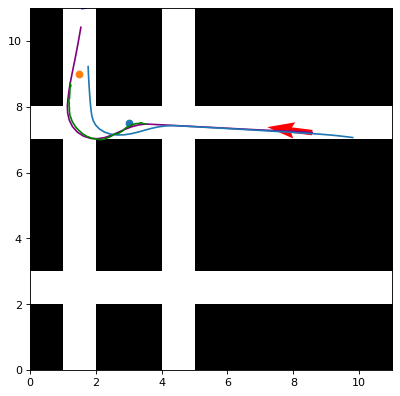

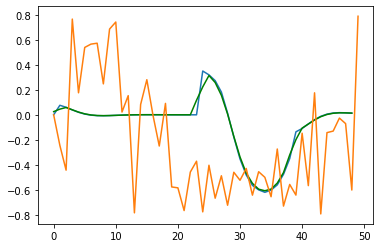

In [170]:
statearr = np.array(statelist)

plt.figure(figsize=(6,6), dpi=80)
plt.imshow(occGrid, extent=[0, gridSize, 0, gridSize], cmap='gray')
#plt.quiver(statearr[:,0] * gridSize, statearr[:,1] * gridSize, np.cos(statearr[:,2]), np.sin(statearr[:,2]), color='purple', scale=16.0, width=0.01)
#plt.quiver(statearr[:,5] * gridSize, statearr[:,6] * gridSize, np.cos(statearr[:,3]), np.sin(statearr[:,3]), color='C0', scale=16.0, width=0.01)
plt.plot(statearr[:,0] * gridSize, statearr[:,1] * gridSize, color='purple')
plt.plot(statearr[:,5] * gridSize, statearr[:,6] * gridSize, color='C0')
plt.scatter(interStarts[:,0] * gridSize, interStarts[:,1] * gridSize)
plt.scatter(interGoals[:,0] * gridSize, interGoals[:,1] * gridSize)
plt.plot(csol[:,0] * gridSize, csol[:,1] * gridSize, color='green')
plt.quiver(start[0] * gridSize, start[1] * gridSize, np.cos(start[2]), np.sin(start[2]), color="red", scale=8.0, width=0.015) # init
plt.quiver(goal[0] * gridSize, goal[1] * gridSize, np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=8.0, width=0.015) # goal
plt.show()

plt.plot(np.arange(statearr.shape[0]), statearr[:, 4])
plt.plot(np.arange(statearr.shape[0]), uniform_filter1d(statearr[:, 4], size=3, origin=0, mode='nearest', axis=0), color='green')
plt.plot(np.arange(csol.shape[0]), csol[:,4])
plt.show()

In [9]:
data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1)))
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/ctrlTrailerGrid_800plans', data[1:], delimiter=',', fmt='%1.6f')

In [8]:
print(nPlans)

821
